## 1. 基础配置

In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import datetime
import yaml

In [229]:
# 设置显示选项以显示所有列
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.width', 1000)        # 设置显示宽度
pd.set_option('display.max_colwidth', None) # 显示完整的列内容

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

In [230]:
# 读取配置文件
config = {}
with open('config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# 全局变量
keyword = config['keyword']


## 2. 数据清洗与预处理

In [231]:
df = pd.read_csv(f'{keyword}_dataset.csv')
print(df.shape)
print(df.describe(include='all'))

(154809, 64)
          type            id  author           mid         typeid typename                                     arcurl           aid          bvid                          title description                                                                      pic          play   video_review      favorites                   tag         review       pubdate      senddate duration badgepay hit_columns  view_type    is_pay  is_union_video  rec_tags new_rec_tags           like                                             upic  corner  cover  desc  url  rec_reason        danmaku  biz_data  is_charge_video        vt  enable_vt  vt_display  subtitle  episode_count_text  release_status  is_intervene      area     style  cate_name  is_live_room_inline  live_status  live_time    online     rank_index    rank_offset    roomid  short_id  spread_id  tags  uface       uid  uname  user_cover  parent_area_id  parent_area_name  watched_show
count   154809  1.548090e+05  154809  1.548090e+05  

很多列没有数据

In [232]:
# 删除无数据的列
df = df.dropna(axis=1, how='all')
print(df.isna().sum().sort_values(ascending=False).head())

description    31768
tag               33
title              1
id                 0
author             0
dtype: int64


In [233]:
# 处理空值
df['tag'] = df['tag'].fillna('')# 对于tag列，填充为空字符串
df = df.dropna(subset=['title'])# 对于title列，删除唯一一个空值行
df['description'] = df['description'].fillna('')# 对于description列，填充为空字符串
print("处理后空值统计:", df.isna().sum().sum(), '; 形状:', df.shape)# 确认处理结果

处理后空值统计: 0 ; 形状: (154808, 45)


In [234]:
print(df.head(1).T)

                                                                                               0
type                                                                                       video
id                                                                               115128594862063
author                                                                               红天使RedAngel
mid                                                                                    437840129
typeid                                                                                        21
typename                                                                                      日常
arcurl                                           http://www.bilibili.com/video/av115128594862063
aid                                                                              115128594862063
bvid                                                                                BV1NSaJzYE9s
title                      【卡丘

In [235]:
# 保留这些列
columns_list = ['bvid','title','tag','description','arcurl','pic',# bv号 标题 标签 描述 链接 封面
                'pubdate','senddate','duration','hit_columns',# 发布时间 发送时间 时长 命中搜索的列
                'typename','typeid','author','mid','upic',# 分区类型 分区类型ID 作者 作者id 作者头像
                'is_pay','is_union_video','is_charge_video',# 是否付费 是否联合投稿 是否是充电视频
                'play','like','favorites','danmaku','review',# 播放数 点赞数 收藏数 弹幕数 评论数
                ]
df = df[columns_list]
print(df.shape)
print(df.describe(include='all'))

(154808, 23)
                bvid                          title                   tag description                                     arcurl                                                                      pic       pubdate      senddate duration hit_columns typename         typeid  author           mid                                             upic    is_pay  is_union_video  is_charge_video          play           like      favorites        danmaku         review
count         154808                         154808                154808      154808                                     154808                                                                   154808  1.548080e+05  1.548080e+05   154808      154808   154808  154808.000000  154808  1.548080e+05                                           154808  154808.0   154808.000000         154808.0  1.548080e+05  154808.000000  154808.000000  154808.000000  154808.000000
unique        141785                         134840          

处理异常数据

bv号有相同的

In [236]:
# 相同bvid只保留一个
df = df.drop_duplicates(subset=['bvid'], keep='first')
print(df.shape)
print(df['bvid'].describe())

(141785, 23)
count           141785
unique          141785
top       BV16q4y1q7AS
freq                 1
Name: bvid, dtype: object


In [237]:
# 显示'hit_columns'列不同值的数量
print(df['hit_columns'].value_counts().sort_values(ascending=False))

hit_columns
['tag']                                      72559
['title', 'tag']                             51610
['title', 'description', 'tag']               5974
['description', 'tag']                        5477
['title']                                     2025
['description']                               1439
['author']                                     751
['author', 'tag']                              674
['title', 'author', 'tag']                     639
['title', 'description']                       364
['title', 'description', 'author', 'tag']      129
['title', 'author']                             84
['description', 'author', 'tag']                33
['description', 'author']                       13
['title', 'description', 'author']              12
[]                                               2
Name: count, dtype: int64


hit_columns中只有'author'的明显是无效数据

In [238]:
# 删除'hit_columns'列中数据为['author']的行
df = df[df['hit_columns'] != '[\'author\']']
print('\'hit_columns\'列为[\'author\']的形状：',df[df['hit_columns'] == '[\'author\']'].shape)
print(df.shape)

'hit_columns'列为['author']的形状： (0, 23)
(141034, 23)


In [239]:
# 1. 处理日期字段（将时间戳转换为可读日期）
df['pubdate_dt'] = pd.to_datetime(df['pubdate'], unit='s')
df['senddate_dt'] = pd.to_datetime(df['senddate'], unit='s')

# 2. 处理视频时长（将"0:51"格式转换为秒数）
def duration_to_seconds(duration_str):
    try:
        if ':' in duration_str:
            parts = duration_str.split(':')
            if len(parts) == 2:
                return int(parts[0]) * 60 + int(parts[1])
            elif len(parts) == 3:
                return int(parts[0]) * 3600 + int(parts[1]) * 60 + int(parts[2])
        return 0
    except:
        return 0

df['duration'] = df['duration'].apply(duration_to_seconds)    
    
# 3. 创建新特征 - 视频年龄（从发布到数据表中最晚的时间）
latest_date = df['pubdate_dt'].max()
df['video_age_days'] = (latest_date - df['pubdate_dt']).dt.days

print(df[['pubdate_dt', 'senddate_dt', 'duration','video_age_days']].head(3))
print(df[['pubdate_dt', 'senddate_dt', 'duration','video_age_days']].describe())

           pubdate_dt         senddate_dt  duration  video_age_days
0 2025-09-01 10:45:56 2025-09-01 15:39:57      1895               0
1 2025-09-01 08:34:41 2025-09-01 08:34:41       180               0
2 2025-09-01 14:48:12 2025-09-01 14:48:13     10460               0
                          pubdate_dt                    senddate_dt      duration  video_age_days
count                         141034                         141034  1.410340e+05   141034.000000
mean   2024-06-14 04:11:27.614787584  2024-07-23 16:02:29.938071808  5.057140e+02      444.082406
min              2021-12-17 17:06:01            2021-12-17 17:06:01  2.000000e+00        0.000000
25%       2023-11-01 14:16:09.500000            2024-01-06 03:55:58  4.000000e+01      221.000000
50%       2024-05-03 07:26:27.500000     2024-07-13 20:33:10.500000  8.000000e+01      486.000000
75%    2025-01-23 09:09:38.750000128            2025-03-28 08:45:43  1.870000e+02      670.000000
max              2025-09-01 15:56:44      

## 3. 探索性数据分析

### 3.1 命中分析

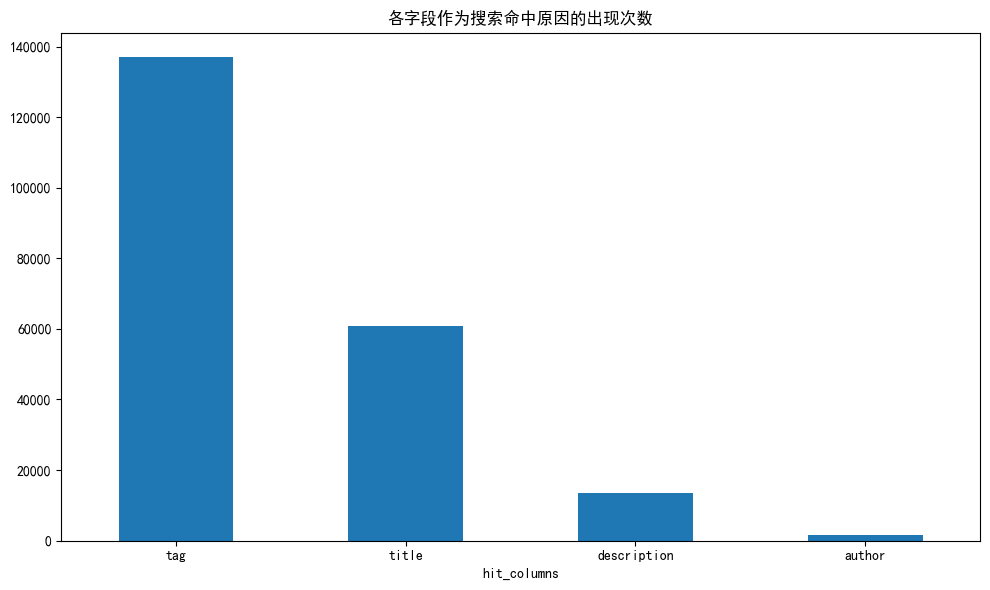

In [249]:
# 将 hit_columns 转换为列表
df['hit_columns'] = df['hit_columns'].apply(ast.literal_eval)

# 使用 explode 展开列表，然后统计每个字段的出现次数
hit_counts = df['hit_columns'].explode().value_counts()

# 创建柱状图
plt.figure(figsize=(10, 6))
hit_counts.plot(kind='bar')
plt.title('各字段作为搜索命中原因的出现次数')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 3.2 发布时间分析

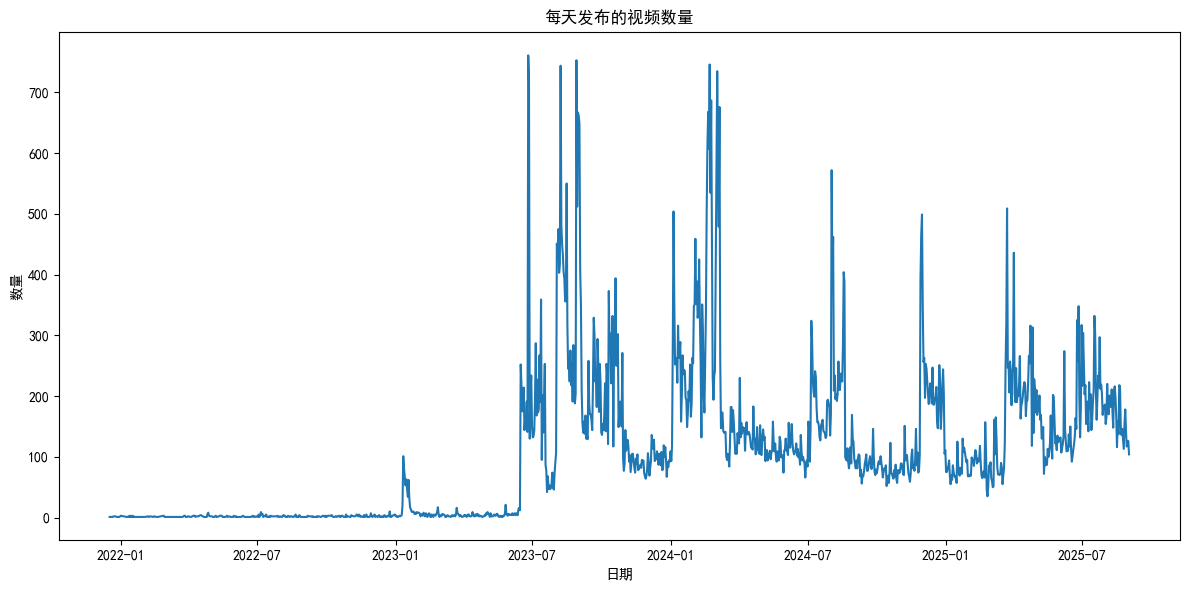

In [251]:
# 统计每天的发布数量，并绘制折线图
daily_counts = df['pubdate_dt'].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line')
plt.title('每天发布的视频数量')
plt.xlabel('日期')
plt.ylabel('数量')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


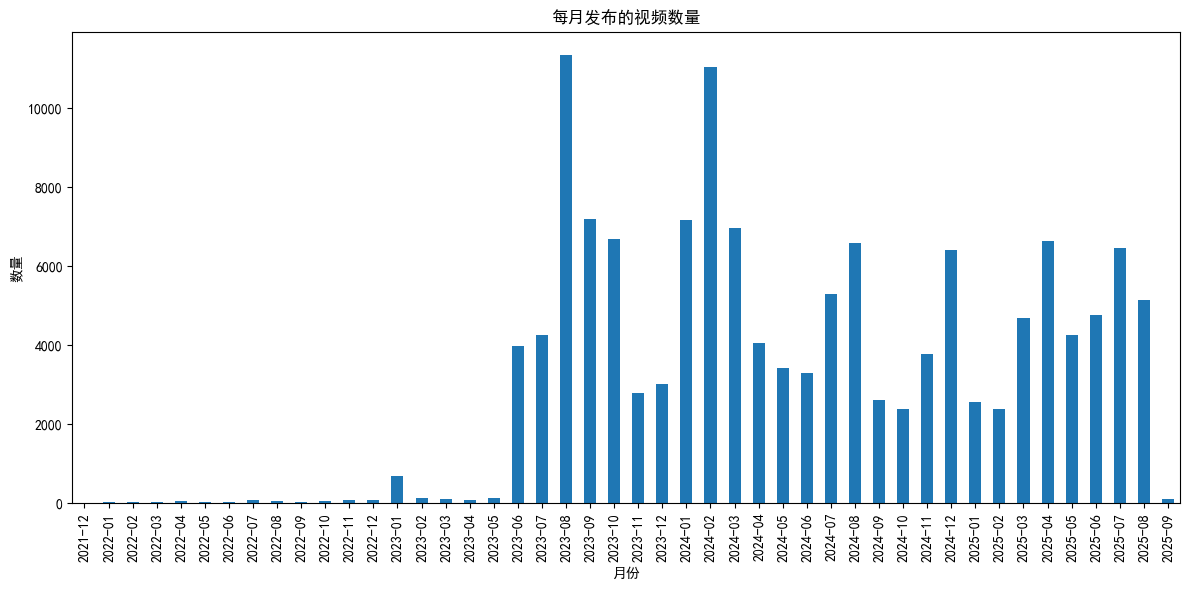

In [255]:
# 统计每月的发布数量，并绘制柱状图
monthly_counts = df['pubdate_dt'].dt.to_period('M').value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar')
plt.title('每月发布的视频数量')
plt.xlabel('月份')
plt.ylabel('数量')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

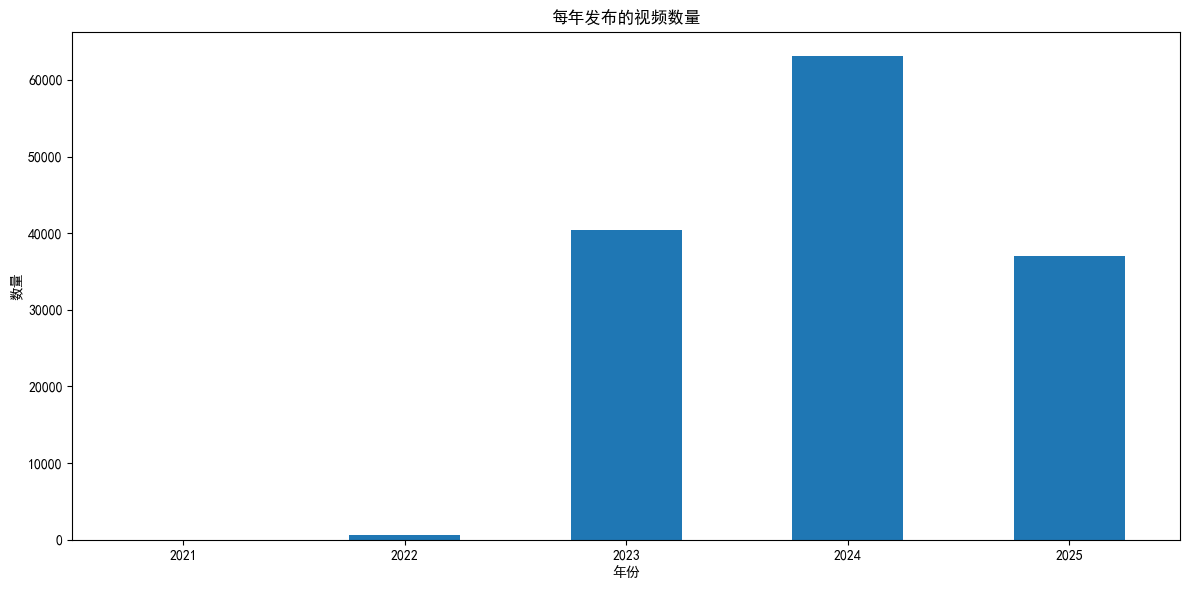

In [256]:
# 统计每年的发布数量，并绘制柱状图
yearly_counts = df['pubdate_dt'].dt.to_period('Y').value_counts().sort_index()

plt.figure(figsize=(12, 6))
yearly_counts.plot(kind='bar')
plt.title('每年发布的视频数量')
plt.xlabel('年份')
plt.ylabel('数量')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 3.3 视频时长分析

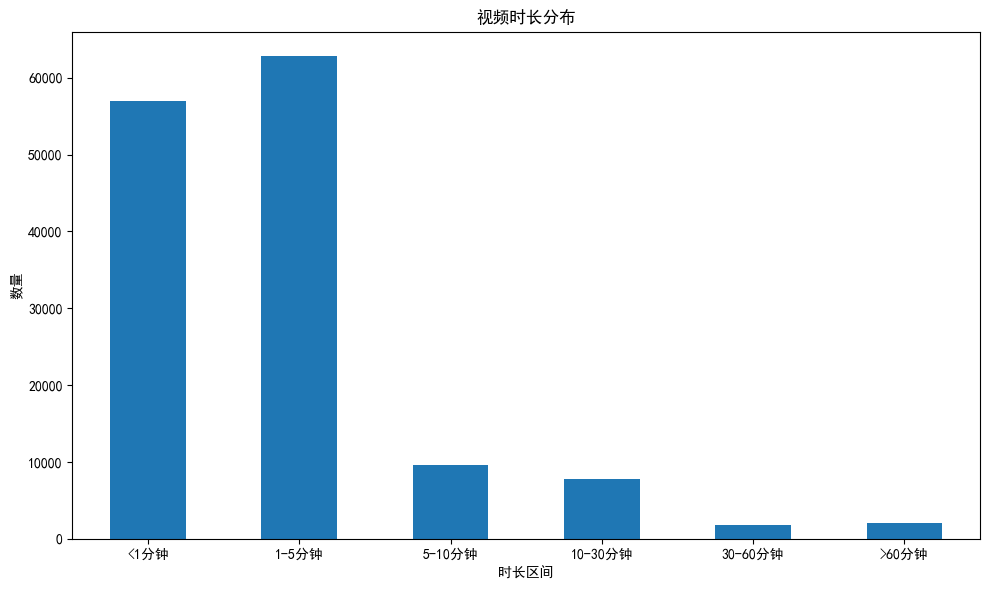

In [260]:
# 将视频时长分为几个区间
bins = [0, 60, 300, 600, 1800, 3600, float('inf')]
labels = ['<1分钟', '1-5分钟', '5-10分钟', '10-30分钟', '30-60分钟', '>60分钟']


# 统计每个区间的视频数量，并绘制柱状图
df['duration'] = pd.cut(df['duration'], bins=bins, labels=labels, right=False)
duration_counts = df['duration'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
duration_counts.plot(kind='bar')
plt.title('视频时长分布')
plt.xlabel('时长区间')
plt.ylabel('数量')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 3.4 视频播放量分析